In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import graphviz
from d2l import torch as d2l

# 多层感知机

## 感知机
感知机是一个用于二分类的线性模型

$$
o=\sigma(\boldsymbol{w}^\top\boldsymbol{x}+b)\quad, \sigma(x)=\begin{cases}
1 &, x \gt 0 \\
-1 &, otherwise
\end{cases}
$$

和在监督式学习中提到的[感知机](../SupervisedLearning/perceptron.ipynb)原理一样。

XOR问题其实就是感知机无法在非线性可分的数据上收敛。

## 多层感知机

如下图，引入两层感知机，其中第一层为黑色直线，第二层为蓝色直线，结合两层感知机的输出作为最终输出就能够解决XOR问题，这种模型称为多层感知机。

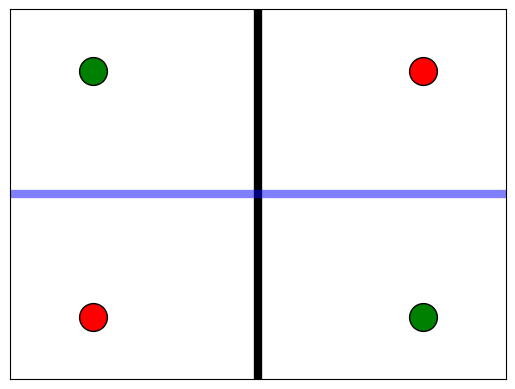

In [2]:
ax = plt.subplot()
ax.set(xticks=[], yticks=[])
ax.set_xlim(-1.5, 1.5), ax.set_ylim(-1.5, 1.5)
x, y = np.array([[1, 1], [1, -1], [-1, 1], [-1, -1]]), np.array([1, -1, -1, 1])
color = ("green", "red")
for cl, c in zip(np.unique(y), color):
    ax.scatter(x=x[y==cl, 0], s=400, y=x[y==cl, 1], c=c, edgecolors='k')
ax.plot([0, 0], [-1.5, 1.5], linewidth=6, color='k')
ax.plot([-1.5, 1.5], [0, 0], linewidth=6, color='blue', alpha=0.5)
plt.show()

多层感知机顾名思义模型包含多层，不再像之前介绍的[线性回归](./linear_regression.ipynb)和[softmax回归](./softmax_regression.ipynb)是单层的神经网络。

多层感知机的网络架构图如下，这是一个包含两层的神经网络模型，其中$h_i$称为隐藏层(hidden layer)。

多层感知机去掉隐藏层就是前面介绍的[softmax回归](./softmax_regression.ipynb)。隐藏层会在线性函数下加一个激活函数，激活函数必须是非线性的，否则多层感知机和单层的softmax回归没有本质区别。

$$
\boldsymbol{h}=\sigma(\boldsymbol{W}\boldsymbol{x}+\boldsymbol{b})
$$

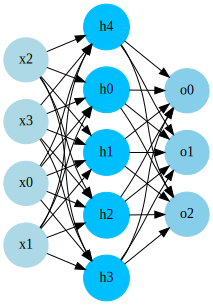

In [3]:
level = (4, 5, 3)
prefix = ('x', 'h', 'o')
G = graphviz.Digraph()
G.attr(rankdir="LR")
G.attr("node", shape="circle", style="filled") 
color = ("lightblue", "deepskyblue", "skyblue")
for l, p, c in zip(level, prefix, color):
    for i in range(l):
        G.node(f"{p}{i}", color=c)
for i in range(1, len(level)):
    for j in range(level[i]):
        head = f"{prefix[i]}{j}"
        for k in range(level[i-1]):
            tail = f"{prefix[i-1]}{k}"
            G.edge(tail, head)
G

## 多层感知机的实现
在Fashion-MNIST数据集上实现多层感知机，并且感知机是包含一层隐藏层，包含`num_hiddens`个神经元。

In [4]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256

W1 = nn.Parameter(torch.randn(
    num_inputs, num_hiddens, requires_grad=True) * 0.01)
b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))
W2 = nn.Parameter(torch.randn(
    num_hiddens, num_outputs, requires_grad=True) * 0.01)
b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))

params = [W1, b1, W2, b2]

激活函数我们使用ReLU函数

$$\mathrm{ReLU}(x)=\max(0, x)$$

In [5]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

由于是分类问题，并且最后一层会加上softmax操作子，因此损失函数还是使用[交叉熵](./softmax_regression.ipynb)，这里就不再赘述。

下面开始训练。

(0.8646666666666667, 0.8468)

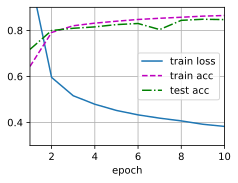

In [6]:
loss = nn.CrossEntropyLoss(reduction='none')

def net(X):
    X = X.reshape((-1, num_inputs))
    H = relu(X@W1 + b1)  # 这里“@”代表矩阵乘法
    return (H@W2 + b2)

def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = d2l.Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), d2l.accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = d2l.Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater, **kwargs):  #@save
    need_plot = kwargs.pop("need_plot") if "need_plot" in kwargs else True
    if need_plot:
        animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        if need_plot:
            animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    # assert train_loss < 0.5, train_loss
    # assert train_acc <= 1 and train_acc > 0.7, train_acc
    # assert test_acc <= 1 and test_acc > 0.7, test_acc
    return train_acc, test_acc

num_epochs, lr = 10, 0.1
updater = torch.optim.SGD(params, lr=lr)
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
train_ch3(net, train_iter, test_iter, loss, num_epochs, updater)

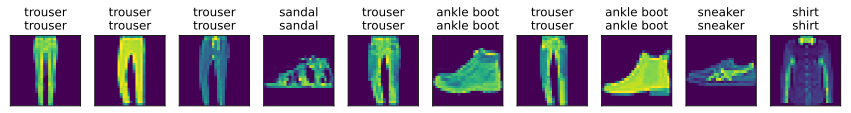

In [7]:
def predict_ch3(net, test_iter, n=6):  #@save
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = np.array([true +'\n' + pred for true, pred in zip(trues, preds)])
    indices = np.random.randint(0, len(y), n)
    d2l.show_images((X[indices]).reshape((n, 28, 28)), 1, n, titles=titles[indices].tolist())

predict_ch3(net, test_iter, 10)

## 基于PyTorch的多层感知机

(0.86315, 0.822)

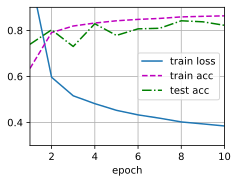

In [8]:
net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784, 256),
                    nn.ReLU(),
                    nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

## 课后习题


- 在所有其他参数保持不变的情况下，更改超参数num_hiddens的值，并查看此超参数的变化对结果有何影响。确定此超参数的最佳值。

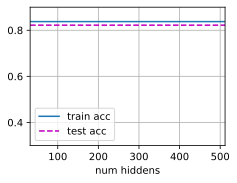

In [9]:
num_hiddens_list = [32, 64, 128, 256, 300, 512]
animator = animator = d2l.Animator(xlabel='num hiddens', xlim=[32, 512], ylim=[0.3, 0.9],
                        legend=['train acc', 'test acc'])
for num_hiddens in num_hiddens_list:
    W1 = nn.Parameter(torch.randn(
        num_inputs, num_hiddens, requires_grad=True) * 0.01)
    b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))
    W2 = nn.Parameter(torch.randn(
        num_hiddens, num_outputs, requires_grad=True) * 0.01)
    b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))
    params = [W1, b1, W2, b2]
    train_acc, test_acc = train_ch3(net, train_iter, test_iter, loss, num_epochs, updater, need_plot=False)
    print(num_hiddens, train_acc, test_acc)
    animator.add(num_hiddens, [train_acc, test_acc])